In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.ion()

import os
import sys
import re
import pdb
import glob
import string
import time
from IPython.display import Image
from pyfasta import Fasta

In [2]:
# Specify input file names
hg38_fasta_file = 'human_data/hg38.fa'
hg38_exon_file = 'human_data/hg38_exons.txt'
splice_site_image = '5p_splice_site.png'

# Load human fasta
hg38 = Fasta(hg38_fasta_file)

# Specify output files
hg38_snp_file = 'hg38_clinvar_snps.txt'
hg38_ss_file = 'hg38_splice_sites.txt'

In [3]:
# Function to compute the reverse complement of a sequence
complement = string.maketrans('ATCGN', 'TAGCN')
def rc(seq):
    return seq.upper().translate(complement)[::-1]

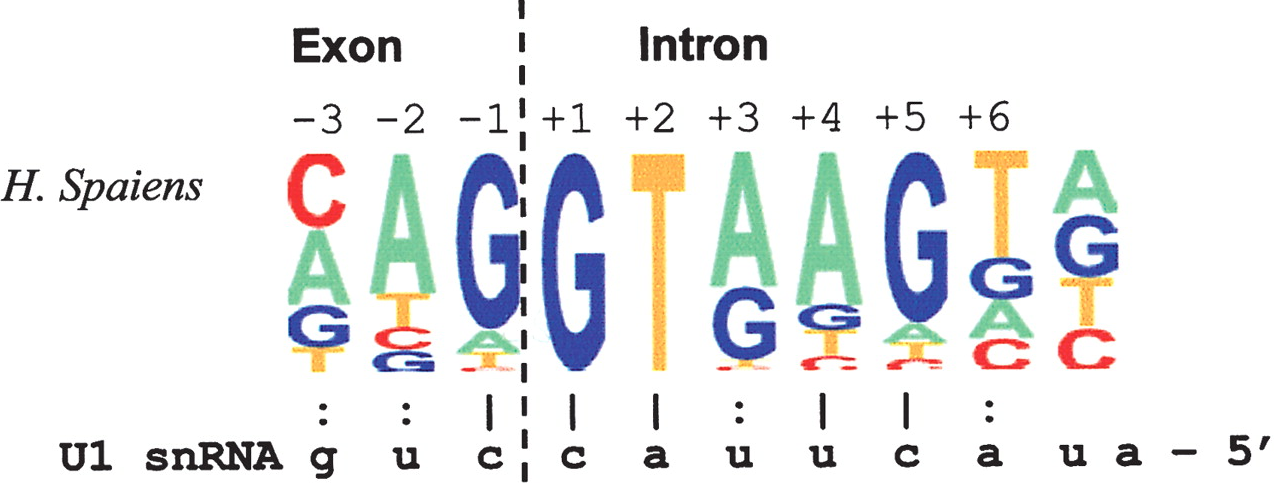

In [4]:
# This is what human splice sites look like. 
# Note that this is 10bp long, so we're extracting one more position from the end
Image(filename=splice_site_image,width=500) 

In [5]:
# Restrict ss and snp data to specified chromosomes
chromosomes = ['chr%d'%n for n in range(1,23)]+['chrX','chrY']
print chromosomes

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX', 'chrY']


In [44]:
# Load exon coordinates
col_names = ['chromosome','start','stop','id','strand']
col_indices = [0,1,2,3,5]
exon_coords_df = pd.read_csv('human_data/hg38_exons.txt',sep='\t',names=col_names,usecols=col_indices)
exon_coords_df = exon_coords_df[exon_coords_df['chromosome'].isin(chromosomes)]
exon_coords_df = exon_coords_df[exon_coords_df['strand'].isin(['+','-'])]
print 'Loaded position data for %d exons.'%len(exon_coords_df)
exon_coords_df.head()

Loaded position data for 1139965 exons.


,chromosome,start,stop,id,strand
0,chr1,17368,17436,uc031tla.1_exon_0_0_chr1_17369_r,-
1,chr1,29553,30039,uc057aty.1_exon_0_0_chr1_29554_f,+
2,chr1,30563,30667,uc057aty.1_exon_1_0_chr1_30564_f,+
3,chr1,30975,31097,uc057aty.1_exon_2_0_chr1_30976_f,+
4,chr1,30266,30667,uc057atz.1_exon_0_0_chr1_30267_f,+


In [52]:
# Compute the coordinates of the (potential) 5' ss at the end of each exon
exon_coords_df['ss_start'] = None # Inclusive start
exon_coords_df['ss_end'] = None # Inclusive end

plus_indices = exon_coords_df['strand']=='+'
exon_coords_df.loc[plus_indices,'ss_start'] = exon_coords_df.loc[plus_indices,'stop']-3
exon_coords_df.loc[plus_indices,'ss_end'] = exon_coords_df.loc[plus_indices,'stop']+8

minus_indices = exon_coords_df['strand']=='-'
exon_coords_df.loc[minus_indices,'ss_start'] = exon_coords_df.loc[minus_indices,'start']-8
exon_coords_df.loc[minus_indices,'ss_end'] = exon_coords_df.loc[minus_indices,'start']+3

# Compute the gene name and exon number
exon_coords_df['exon_name'] = ['_'.join(x.split('_')[:3]) for x in exon_coords_df['id']]

# Make sure exons are unique
num_exons = len(exon_coords_df)
num_unique_exon_names = len(set(exon_coords_df['exon_name']))
print 'num exons: %d'%num_exons
print 'num unique exon names: %d'%num_unique_exon_names
if num_exons == num_unique_exon_names:
    print 'All exon names are unique'
else:
    print 'Exon names are not unqiue'

exon_coords_df.head()

num exons: 1139965
num unique exon names: 1139965
All exon names are unique


,chromosome,start,stop,id,strand,ss_start,ss_end,exon_name
0,chr1,17368,17436,uc031tla.1_exon_0_0_chr1_17369_r,-,17360,17371,uc031tla.1_exon_0
1,chr1,29553,30039,uc057aty.1_exon_0_0_chr1_29554_f,+,30036,30047,uc057aty.1_exon_0
2,chr1,30563,30667,uc057aty.1_exon_1_0_chr1_30564_f,+,30664,30675,uc057aty.1_exon_1
3,chr1,30975,31097,uc057aty.1_exon_2_0_chr1_30976_f,+,31094,31105,uc057aty.1_exon_2
4,chr1,30266,30667,uc057atz.1_exon_0_0_chr1_30267_f,+,30664,30675,uc057atz.1_exon_0


In [53]:
# Create data frame with just splice site coordinates and strand
ss_df = exon_coords_df[['chromosome','ss_start','ss_end','strand','exon_name']].copy()
ss_df.rename(columns={'ss_start':'start','ss_end':'end'},inplace=True)
ss_df.reset_index(drop=True,inplace=True)

ss_df.head()

,chromosome,start,end,strand,exon_name
0,chr1,17360,17371,-,uc031tla.1_exon_0
1,chr1,30036,30047,+,uc057aty.1_exon_0
2,chr1,30664,30675,+,uc057aty.1_exon_1
3,chr1,31094,31105,+,uc057aty.1_exon_2
4,chr1,30664,30675,+,uc057atz.1_exon_0


In [54]:
# Allocate memory
print 'Allocating memory...'
ss_df['ss'] = 'N'*11
num_ss = len(ss_df)

# Load all splice site sequences
print 'Looking up splice site sequences...'
start_time = time.time()
for index, row in ss_df.iterrows():
    if index%50000==0 and index>0:
        elapsed_time = (time.time() - start_time)/60
        remaining_time = (num_ss - index)*elapsed_time/index
        print 'Processing splice site %d/%d. %.1f min elapsed, ~%.1f min remaining.'%\
            (index,num_ss,elapsed_time,remaining_time)
    start = row['start']
    end = row['end']
    chromosome = row['chromosome']
    seq = str(hg38[chromosome][start:end].upper())
    if row['strand']=='-':
        seq = rc(seq)
    ss_df.loc[index,'ss'] = seq
    
# Record whether splice splice site has G[TC] in right location
ss_pattern = re.compile('...G[TC]......')
ss_df['valid'] = [bool(re.match(ss_pattern,seq)) for seq in ss_df['ss']]

Allocating memory...
Looking up splice site sequences...
Processing splice site 50000/1139965. 0.3 min elapsed, ~7.3 min remaining.
Processing splice site 100000/1139965. 0.7 min elapsed, ~7.2 min remaining.
Processing splice site 150000/1139965. 1.1 min elapsed, ~6.9 min remaining.
Processing splice site 200000/1139965. 1.4 min elapsed, ~6.6 min remaining.
Processing splice site 250000/1139965. 1.7 min elapsed, ~6.1 min remaining.
Processing splice site 300000/1139965. 2.0 min elapsed, ~5.7 min remaining.
Processing splice site 350000/1139965. 2.4 min elapsed, ~5.4 min remaining.
Processing splice site 400000/1139965. 2.7 min elapsed, ~5.0 min remaining.
Processing splice site 450000/1139965. 3.0 min elapsed, ~4.6 min remaining.
Processing splice site 500000/1139965. 3.3 min elapsed, ~4.3 min remaining.
Processing splice site 550000/1139965. 3.7 min elapsed, ~3.9 min remaining.
Processing splice site 600000/1139965. 4.0 min elapsed, ~3.6 min remaining.
Processing splice site 650000/11

In [55]:
# Compute percentage of correct sites on pos and neg strands
num_pos_ss = sum((ss_df['strand']=='+')) 
num_pos_ss_ok = sum((ss_df['strand']=='+') & ss_df['valid'])
print '+ strand: %.3f%% of splice sites are valid'%(100*num_pos_ss_ok/num_pos_ss)

num_neg_ss = sum((ss_df['strand']=='-')) 
num_neg_ss_ok = sum((ss_df['strand']=='-') & ss_df['valid'])
print '- strand: %.3f%% of splice sites are valid'%(100*num_neg_ss_ok/num_neg_ss)

# Save splice sites
ss_df.to_csv(hg38_ss_file,sep='\t')
print 'Done'

ss_df.head()

+ strand: 85.871% of splice sites are valid
- strand: 85.864% of splice sites are valid
Done


,chromosome,start,end,strand,exon_name,ss,valid
0,chr1,17360,17371,-,uc031tla.1_exon_0,TAGGTAGAAGA,True
1,chr1,30036,30047,+,uc057aty.1_exon_0,TGGGTAGAGTT,True
2,chr1,30664,30675,+,uc057aty.1_exon_1,GAGGTAAAGAA,True
3,chr1,31094,31105,+,uc057aty.1_exon_2,TATGATTTTAA,False
4,chr1,30664,30675,+,uc057atz.1_exon_0,GAGGTAAAGAA,True


In [56]:
# Load clinvar data
col_names = ['chromosome','start','end','mut']
clinvar_df = pd.read_csv('human_data/clinvar.txt',sep='\t',names=col_names,usecols=range(len(col_names)))
print '%d clinvar entries loaded.'%len(clinvar_df)

# Extract snps
snp_pattern = re.compile('.>.')
indices = (clinvar_df['end']-clinvar_df['start']==1) & \
    np.array([bool(re.match(snp_pattern,mut)) for mut in clinvar_df['mut']])
df = clinvar_df.loc[indices,:].copy()
df.rename(columns={'start':'pos'},inplace=True)
df['wt'] = [mut[0] for mut in df['mut']]
df['var'] = [mut[2] for mut in df['mut']]
snp_df = df[['chromosome','pos','wt','var']].copy()
snp_df['pos'] = snp_df['pos'].astype(int)
snp_df = snp_df[snp_df['chromosome'].isin(chromosomes)]
snp_df.reset_index(inplace=True,drop=True)
print 'saving results for %d snps to %s.'%(len(snp_df),hg38_snp_file)
snp_df.to_csv(hg38_snp_file,sep='\t')
print 'Done!'
snp_df.head()

291775 clinvar entries loaded.
saving results for 254491 snps to hg38_clinvar_snps.txt.
Done!


,chromosome,pos,wt,var
0,chr1,1014142,C,T
1,chr1,1014227,G,A
2,chr1,1014358,G,T
3,chr1,1020182,G,C
4,chr1,1020215,C,G


--------

In [57]:
# Load ss data from file
ss_df = pd.read_csv(hg38_ss_file,delim_whitespace=True)
print '%d ss loaded.'%len(ss_df)
print 'ss chromosomes listed: %s'%str(set(ss_df['chromosome']))
ss_df.head()

1139965 ss loaded.
ss chromosomes listed: set(['chrY', 'chrX', 'chr13', 'chr12', 'chr11', 'chr10', 'chr17', 'chr16', 'chr15', 'chr14', 'chr19', 'chr18', 'chr22', 'chr20', 'chr21', 'chr7', 'chr6', 'chr5', 'chr4', 'chr3', 'chr2', 'chr1', 'chr9', 'chr8'])


,chromosome,start,end,strand,exon_name,ss,valid
0,chr1,17360,17371,-,uc031tla.1_exon_0,TAGGTAGAAGA,True
1,chr1,30036,30047,+,uc057aty.1_exon_0,TGGGTAGAGTT,True
2,chr1,30664,30675,+,uc057aty.1_exon_1,GAGGTAAAGAA,True
3,chr1,31094,31105,+,uc057aty.1_exon_2,TATGATTTTAA,False
4,chr1,30664,30675,+,uc057atz.1_exon_0,GAGGTAAAGAA,True


In [58]:
# Load snp data from file
snp_df = pd.read_csv(hg38_snp_file,delim_whitespace=True)
print '%d snps loaded.'%len(snp_df)
print 'snp chromosomes listed: %s'%str(set(snp_df['chromosome']))
snp_df.head()

254491 snps loaded.
snp chromosomes listed: set(['chrY', 'chrX', 'chr13', 'chr12', 'chr11', 'chr10', 'chr17', 'chr16', 'chr15', 'chr14', 'chr19', 'chr18', 'chr22', 'chr20', 'chr21', 'chr7', 'chr6', 'chr5', 'chr4', 'chr3', 'chr2', 'chr1', 'chr9', 'chr8'])


,chromosome,pos,wt,var
0,chr1,1014142,C,T
1,chr1,1014227,G,A
2,chr1,1014358,G,T
3,chr1,1020182,G,C
4,chr1,1020215,C,G


In [62]:
# Identify variants within splice sites
chromosomes = list(set(snp_df['chromosome'].values))
chromosomes.sort()

# Make df to store results in
annotated_snp_df = snp_df.copy()
annotated_snp_df['in_ss'] = False
annotated_snp_df['ss'] = None
annotated_snp_df['ss_start'] = None
annotated_snp_df['ss_end'] = None
annotated_snp_df['ss_strand'] = None
annotated_snp_df['exon_name'] = None

# Iterate over chromosomes
for chromosome in chromosomes:
    ss_chr_df = ss_df[ss_df['chromosome'] == chromosome].copy()
    snp_chr_df = snp_df[snp_df['chromosome'] == chromosome].copy()
    
    print 'chromosome: %s,\tnum ss: %d,\tnum snps: %d'%(chromosome,len(ss_chr_df),len(snp_chr_df))

    # Sort indices
    ss_chr_df.sort_values(by='start',inplace=True)
    snp_chr_df.sort_values(by='pos',inplace=True)
    
    # Make snp copy with space for splice site annotation

    
    snp_iterr = snp_chr_df.iterrows()
    for ss_index, ss_row in ss_chr_df.iterrows():
        start = ss_row['start']
        end = start+11
        
        # Find next snp at or after start
        try:
            snp_index, snp_row = snp_iterr.next()
            pos = snp_row['pos']
        except StopIteration:
            pos = np.Inf
        
        while pos < start:
            try:
                snp_index, snp_row = snp_iterr.next()
                pos = snp_row['pos']
            except StopIteration:
                pos = np.Inf
        
        if pos == np.Inf:
            break

        if snp_row['pos'] < end:
            #print 'snp in ss found at chromosome %s, pos %d'%(chromosome, snp_row['pos'])
            annotated_snp_df.loc[snp_index,'ss'] = ss_row['ss']
            annotated_snp_df.loc[snp_index,'ss_start'] = start
            annotated_snp_df.loc[snp_index,'ss_end'] = end
            annotated_snp_df.loc[snp_index,'ss_strand'] = ss_row['strand']
            annotated_snp_df.loc[snp_index,'exon_name'] = ss_row['exon_name']
            annotated_snp_df.loc[snp_index,'in_ss'] = True
            
    print 'num annotated snps found: %d'%annotated_snp_df['in_ss'].sum()
    
print 'Done!'

chromosome: chr1,	num ss: 105136,	num snps: 19254
num annotated snps found: 0
chromosome: chr10,	num ss: 40506,	num snps: 9681
num annotated snps found: 0
chromosome: chr11,	num ss: 68484,	num snps: 16543
num annotated snps found: 0
chromosome: chr12,	num ss: 68513,	num snps: 12466
num annotated snps found: 0
chromosome: chr13,	num ss: 17248,	num snps: 8414
num annotated snps found: 48
chromosome: chr14,	num ss: 40977,	num snps: 7593
num annotated snps found: 48
chromosome: chr15,	num ss: 42383,	num snps: 7938
num annotated snps found: 48
chromosome: chr16,	num ss: 54563,	num snps: 13720
num annotated snps found: 48
chromosome: chr17,	num ss: 72732,	num snps: 17818
num annotated snps found: 48
chromosome: chr18,	num ss: 19712,	num snps: 4308
num annotated snps found: 48
chromosome: chr19,	num ss: 69695,	num snps: 11896
num annotated snps found: 48
chromosome: chr2,	num ss: 88162,	num snps: 28258
num annotated snps found: 48
chromosome: chr20,	num ss: 24699,	num snps: 4463
num annotated

In [63]:
# Only list splice sites that were annotated
annotated_snp_df = annotated_snp_df[annotated_snp_df['in_ss']]

In [64]:
# See how many splice sites have the wt sequence at the correct position
print len(annotated_snp_df)
annotated_snp_df.head(10)

64


,chromosome,pos,wt,var,in_ss,ss,ss_start,ss_end,ss_strand,exon_name
67770,chr5,226044,A,C,True,AGGGTAAGGCC,226044,226055,+,uc063buz.1_exon_4
67771,chr5,226054,C,T,True,AGGGTAAGGCC,226044,226055,+,uc011clw.3_exon_3
67826,chr5,233634,C,T,True,TGGAGATCCGA,233626,233637,+,uc063bvc.1_exon_3
67828,chr5,233648,C,T,True,AAGGTGCGTGT,233642,233653,+,uc003jao.5_exon_7
67829,chr5,233649,G,C,True,AAGGTGCGTGT,233642,233653,+,uc063bvb.1_exon_2
67830,chr5,233649,G,A,True,AAGGTGCGTGT,233642,233653,+,uc063buu.1_exon_5
67854,chr5,235342,A,G,True,CAGGTGATGGT,235336,235347,+,uc063buv.1_exon_8
67867,chr5,236520,C,T,True,CAACCGCCTCG,236513,236524,+,uc063bvd.1_exon_2
67879,chr5,236599,G,C,True,CTGGTAAGTGT,236596,236607,+,uc063bvb.1_exon_4
67880,chr5,236605,G,C,True,CTGGTAAGTGT,236596,236607,+,uc063bvf.1_exon_0


In [65]:
# Check to make sure that wt base is valid
annotated_snp_df['pos_in_ss'] = None
annotated_snp_df['wt_in_ss'] = None
annotated_snp_df['var_in_ss'] = None
ss_length = 11
for index, row in annotated_snp_df.iterrows():
    if row['ss_strand']=='+':
        pos_in_ss = row['pos']-row['ss_start']
        wt_in_ss = row['wt']
        var_in_ss = row['var']

    elif row['ss_strand']=='-':
        pos_in_ss = ss_length-1-(row['pos']-row['start'])
        wt_in_ss = rc(row['wt'])
        var_in_ss = rc(row['var'])

    else:
        raise Exception
    
    # Make sure the wt nucleotide in clinvar matches the ss
    if not wt_in_ss==row['ss'][pos_in_ss]:
        raise Exception
        
    annotated_snp_df.loc[index,['pos_in_ss','wt_in_ss','var_in_ss']] = [pos_in_ss, wt_in_ss, var_in_ss]
    

In [31]:
annotated_snp_df.head()

,chromosome,pos,wt,var,in_ss,ss,ss_start,ss_end,ss_strand,pos_in_ss,wt_in_ss,var_in_ss
67770,chr5,226044,A,C,True,AGGGTAAGGCC,226044,226055,+,0,A,C
67771,chr5,226054,C,T,True,AGGGTAAGGCC,226044,226055,+,10,C,T
67826,chr5,233634,C,T,True,TGGAGATCCGA,233626,233637,+,8,C,T
67828,chr5,233648,C,T,True,AAGGTGCGTGT,233642,233653,+,6,C,T
67829,chr5,233649,G,C,True,AAGGTGCGTGT,233642,233653,+,7,G,C


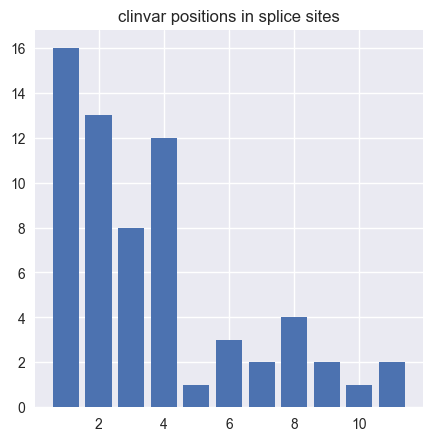

In [39]:
# Histogram clinvar mutations within ss
pos_list = list(annotated_snp_df['pos_in_ss'].values)
poss = np.arange(0,ss_length)
counts = np.array([pos_list.count(p) for p in poss])

plt.figure(figsize=[5,5])
plt.bar(poss+1,counts)
plt.title('clinvar positions in splice sites')